

# 期中專案: 服務業實習生日誌情緒分析
**Author:** 周紘樟、鍾君右、林妤姍、陳亞琦<br>
**Date created:** 2021/11/26<br>
**Last modified:** 2021/11/26<br>


資料來源：某位教授的學生實習週誌

資料年份：2018年-2021年

分析目的：
    希望能挖掘出學生在實習中最常碰到的問題、
    學生實習的成效及留任程度以及情緒的變化。 

## 大綱
+ 1. 資料前處理
    + 1.1 基本資料介紹
    + 1.2 資料清理
    + 1.3 日期處理
    + 1.4 文章斷詞
+ 2. lexicon-base 情緒分析
    + 2.1 準備台大情緒字典
    + 2.2 情緒字典與斷詞結果進行合併
    + 2.3 實習生各自的情緒分析
    + 2.4 依照月份的整體情緒走向
    + 2.5 文字雲
    + 2.6 情緒代表字
    + 2.7 歸類正負面文章
    + 2.8 情緒關鍵字
+ 3. Pairwise correlation
    + 3.1 相關性最高的詞彙
+ 4. 結論    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 移至當前工作目錄
%cd /content/drive/Shareddrives/社媒/Mid_Project

/content/drive/Shareddrives/社媒/Mid_Project


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

In [ ]:
# cloab 字體設定
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

## 1. 資料前處理
處理實習生日誌的excel檔案，包含日期處理，加上員工編號。

### 1.1 基本資料介紹
- 資料來源: 實習生日誌
- 資料集： `raw_data/Meta-1.csv`、`raw_data/Meta-2.csv`
- 資料時間：2018/04-2021/05
- 共有39位實習生，超過1000篇日誌。

主要分析實習生的情緒變化。本次主要針對以下方向分析：
1. 各個實習生在實習過程中的情緒變化？
2. 每個月實習生們的總體情緒走向?
3. 正面和負面時間點上的差異？
4. 正面和負面討論的情緒分數大約多少？

In [ ]:
#匯入資料
MetaData1 = pd.read_csv('./raw_data/Meta-1.csv', encoding='UTF-8')
MetaData2 = pd.read_csv('./raw_data/Meta-2.csv', encoding='UTF-8')

In [ ]:
print(f"共有 {MetaData1.shape[0]} 篇日誌") #(row,column)
MetaData1.head(3)

共有 354 篇日誌


,artDate,year,intern_id,content
0,12/05-12/11,109,1,開始在本店上班外，還要去別家店支援，每次支援的時候都只會想客群、客人、活動內容，活動內容好難...
1,12/12-12/18,109,1,快到聖誕節了，每間店開始以了聖誕節的氣方以及裝飾，這禮拜不忘要跟客人推薦聖誕節蛋糕，但是自己...
2,12/19-12/25,109,1,這個月開始要衝刺聖誕節蛋糕的預購，發現在一人店根本不知道到底活動內容以及折扣跟優惠，當客人詢...


In [ ]:
print(f"共有 {MetaData2.shape[0]} 篇日誌") #(row,column)
MetaData2.head(3)

共有 908 篇日誌


,artDate,intern_id,content
0,2018/7/8,18,7月開始是大四實習的第一個月，這個禮拜帶了兩個新人去公司上課，希望他們能順利通過考試。除了帶...
1,2018/7/15,18,7月開始是大四實習的第一個月，也帶了新人去上課，每天都約了客戶，閒暇的時間也有去內湖開發，內...
2,2018/7/22,18,7月開始是大四實習的第一個月，一樣每天都有行程，開發與見客戶。有客戶被抽到抽樣體檢，我帶著客...


### 1.2 日期處理 
- MetaData1 : 分割日期區間、民國年轉成西元年

Meta1

In [ ]:
#調整日期格式:原本"artDate"欄位是日期的區間，所以用'-'分割兩個日期，再取得位於第一個的開始日期
MetaData1['artDate'] = MetaData1.artDate.apply(lambda x: x.split('-')[0])

In [ ]:
MetaData1.head(3)

,artDate,year,intern_id,content
0,12/05,109,1,開始在本店上班外，還要去別家店支援，每次支援的時候都只會想客群、客人、活動內容，活動內容好難...
1,12/12,109,1,快到聖誕節了，每間店開始以了聖誕節的氣方以及裝飾，這禮拜不忘要跟客人推薦聖誕節蛋糕，但是自己...
2,12/19,109,1,這個月開始要衝刺聖誕節蛋糕的預購，發現在一人店根本不知道到底活動內容以及折扣跟優惠，當客人詢...


In [ ]:
#把"year"欄位的民國年轉成西元年
MetaData1['year'] = MetaData1.year.apply(lambda x: x + 1911)

In [ ]:
#將年份欄位與開始日期合併
MetaData1['artDate'] = MetaData1['year'].apply(str) + '/' + MetaData1['artDate']

In [ ]:
#刪除"year"欄位
MetaData1 = MetaData1.drop("year", axis = 1)

In [ ]:
#合併MetaData1和MetaData2的資料
MetaData = MetaData1.append(MetaData2,ignore_index=True)

In [ ]:
MetaData.head()

,artDate,intern_id,content
0,2020/12/05,1,開始在本店上班外，還要去別家店支援，每次支援的時候都只會想客群、客人、活動內容，活動內容好難...
1,2020/12/12,1,快到聖誕節了，每間店開始以了聖誕節的氣方以及裝飾，這禮拜不忘要跟客人推薦聖誕節蛋糕，但是自己...
2,2020/12/19,1,這個月開始要衝刺聖誕節蛋糕的預購，發現在一人店根本不知道到底活動內容以及折扣跟優惠，當客人詢...
3,2020/12/26,1,經歷了上禮拜的腸胃炎，這禮拜沒有完全復原就上工了，雖然生病的時候有發生了一些事情，但是想了想...
4,2021/01/02,1,經歷了聖誕節，接下來重點活動是春節了，春節禮盒、發糕，第一次知道我們原來有在做發糕，而且還有...


### 1.3 資料清理  
- 去除NA值
- 去除不是中文的字詞

In [ ]:
# 移除內容為na值的資料
MetaData.dropna(subset = ["content"], inplace=True)

In [ ]:
MetaData['content'] = MetaData.content.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))

In [ ]:
MetaData.head()

,artDate,intern_id,content
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...
1,2020/12/12,1,快到聖誕節了每間店開始以了聖誕節的氣方以及裝飾這禮拜不忘要跟客人推薦聖誕節蛋糕但是自己站店還...
2,2020/12/19,1,這個月開始要衝刺聖誕節蛋糕的預購發現在一人店根本不知道到底活動內容以及折扣跟優惠當客人詢問時...
3,2020/12/26,1,經歷了上禮拜的腸胃炎這禮拜沒有完全復原就上工了雖然生病的時候有發生了一些事情但是想了想我也不...
4,2021/01/02,1,經歷了聖誕節接下來重點活動是春節了春節禮盒發糕第一次知道我們原來有在做發糕而且還有三個顏色每...


### 1.4 文章斷詞
中文文集我們使用`jieba`套件進行斷詞與移除停用字

In [ ]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
    
# 參數形式手動加入停用字
user_stop = ["之間","這週","真的","希望","禮拜", "東西", "特別", "很快", "一點", "那位", "這段", "過得", "這間", "這是", "這份","有時候", "第二個", "第十", "喜餅", "地方", "事物"]
for i in user_stop:
    stopWords.append(i)

Building prefix dict from /content/drive/Shareddrives/社媒/Mid_Project/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.ub4303ea888444d671fffa1749f1e90bc.cache
Loading model cost 2.464 seconds.
Prefix dict has been built successfully.


In [ ]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [ ]:
MetaData['word'] = MetaData.content.apply(getToken)

In [ ]:
# 將word欄位展開
MetaData_token = MetaData.explode('word') 

In [ ]:
MetaData_token.head(3)

,artDate,intern_id,content,word
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,本店
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,上班
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,別家


In [ ]:
#轉換日期格式
MetaData_token['artDate'] = pd.to_datetime(MetaData_token['artDate'], format="%Y/%m/%d")

In [ ]:
#新增"artMonth"欄位，紀錄年分和月份作為後續分析使用
MetaData_token['artMonth'] = MetaData_token.artDate.apply(lambda x: x.strftime('%Y-%m'))
MetaData_token.head(3)

,artDate,intern_id,content,word,artMonth
0,2020-12-05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,本店,2020-12
0,2020-12-05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,上班,2020-12
0,2020-12-05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,別家,2020-12


In [ ]:
#計算每天不同字的詞頻
word_count = MetaData_token.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head(3)

,artDate,word,size
19363,2019-05-01,工作,101
18068,2019-04-30,客人,91
16247,2019-04-19,客人,80


In [ ]:
#計算每月不同字的詞頻
word_count_mon = MetaData_token.groupby(['artMonth','word'],as_index=False).size()
word_count_mon.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count_mon = word_count_mon[word_count_mon['size']>3]  #過濾出現太少次的字
word_count_mon.head(3)

,artMonth,word,size
11556,2019-04,客人,213
8284,2018-12,客人,135
8360,2018-12,工作,128


In [ ]:
#計算每位實習生不同字的詞頻
word_count_intern = MetaData_token.groupby(['artMonth','intern_id','word'],as_index=False).size()
word_count_intern.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count_intern = word_count_intern[word_count_intern['size']>3]  #過濾出現太少次的字
word_count_intern.head(3)

,artMonth,intern_id,word,size
17385,2019-04,39,客人,213
19789,2019-05,39,工作,113
17451,2019-04,39,工作,90


## 2. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 2.1 準備台大情緒字典  
- NTUSD

In [ ]:
filepath = ['negative','positive']
d_ntusd = []
for file in filepath:
    filename = f"./dict/ntusd-{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
      for line in f:
        d_ntusd.append([line.splitlines(),file])

In [ ]:
df_ntusd = pd.DataFrame(d_ntusd,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_ntusd.head()

,word,sentiments
0,幹,negative
1,一下子爆發,negative
2,一下子爆發的一連串,negative
3,一巴掌,negative
4,一再,negative


### 2.2 情緒字典與斷詞結果進行合併

##### 合併NTUSD 情緒字典與斷詞結果

In [ ]:
#文章和與NTUSD情緒字典做合併
data_ntusd = pd.merge(MetaData_token, df_ntusd, on=['word'],how='left')

#算出每月情緒總和(sentiment_count)
ntusd_sentiment_count = data_ntusd.groupby(['artMonth','sentiments'],as_index=False).size()
ntusd_sentiment_count.head()

,artMonth,sentiments,size
0,2018-04,negative,19
1,2018-04,positive,9
2,2018-05,negative,23
3,2018-05,positive,60
4,2018-07,negative,294


In [ ]:
#算出每個實習生的情緒總和(ntusd_sentiment_individual_count)
ntusd_sentiment_individual_count = data_ntusd.groupby(['artMonth','intern_id','sentiments'],as_index=False).size()
ntusd_sentiment_individual_count.head()

,artMonth,intern_id,sentiments,size
0,2018-04,39,negative,19
1,2018-04,39,positive,9
2,2018-05,39,negative,23
3,2018-05,39,positive,60
4,2018-07,18,negative,5


In [ ]:
#指定個案每個月情緒總和(sentiment_count)
def person_sentiment(id):
    ntusd_sentiment_individual_count1 = ntusd_sentiment_individual_count[ntusd_sentiment_individual_count['intern_id']==id]
    return ntusd_sentiment_individual_count1

In [ ]:
#指定篩選出intern_id=39的資料
ntusd_sentiment_individual_spec = person_sentiment(39)
ntusd_sentiment_individual_spec.head()

,artMonth,intern_id,sentiments,size
0,2018-04,39,negative,19
1,2018-04,39,positive,9
2,2018-05,39,negative,23
3,2018-05,39,positive,60
169,2018-11,39,negative,35


### 2.3 每月正負向情緒分數聲量折線圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

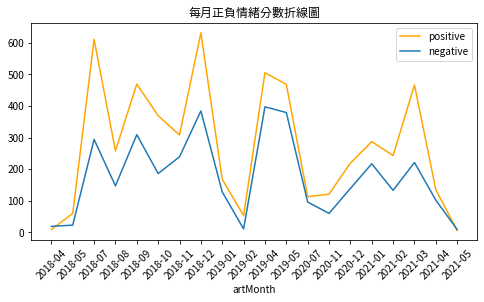

In [ ]:
p = ntusd_sentiment_count[ntusd_sentiment_count['sentiments']=='positive']
n = ntusd_sentiment_count[ntusd_sentiment_count['sentiments']=='negative']

plt.figure(figsize=(8,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams["font.family"] = "Taipei Sans TC Beta" # 將字體變成台北思源黑體
plt.title('每月正負情緒分數折線圖')
plt.plot(p['artMonth'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artMonth'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('artMonth')
plt.show()

可以看到幾乎每天正面情緒高於負面情緒。因為寒假的原因，在2019年一月日誌輸入量極少。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


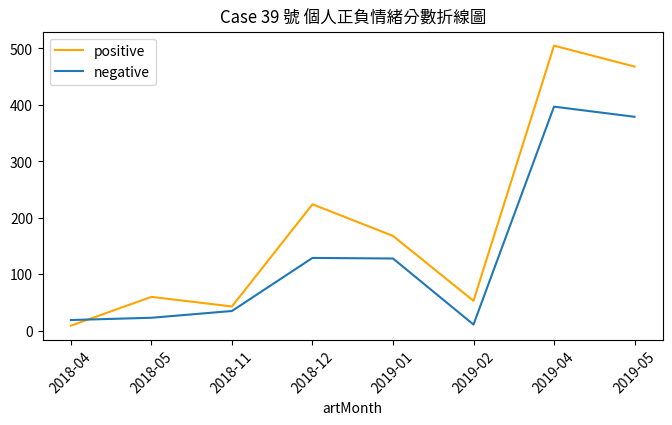

In [ ]:
#實習生個人正負情緒分數折線圖
p = ntusd_sentiment_individual_spec[ntusd_sentiment_individual_spec['sentiments']=='positive']
n = ntusd_sentiment_individual_spec[ntusd_sentiment_individual_spec['sentiments']=='negative']
ntusd_sentiment_individual_spec['intern_id'] = ntusd_sentiment_individual_spec['intern_id'].apply(str)
id = ntusd_sentiment_individual_spec.loc[0][1]
plt.figure(figsize=(8,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams["font.family"] = "Taipei Sans TC Beta" # 將字體變成台北思源黑體
plt.title('Case '+id+' 號 個人正負情緒分數折線圖')
plt.plot(p['artMonth'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artMonth'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('artMonth')
plt.show()

我們抓了一個實習一年的第39號實習生，可以看見一開始負面比正面情緒高出了一點，可能是在剛開始實習時會比較緊張。之後，正面情緒一直高於負面的。

### 2.4 正負向情緒分數比例折線圖

In [ ]:
sentiment_count_r = ntusd_sentiment_count.assign(ratio = ntusd_sentiment_count.groupby(['artMonth'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

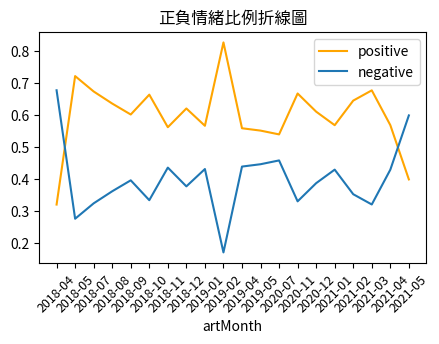

In [ ]:
# sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] > '2021/03/13']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams["font.family"] = "Taipei Sans TC Beta" # 將字體變成台北思源黑體

plt.title('正負情緒比例折線圖')
plt.plot(p['artMonth'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artMonth'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend() #顯示圖例
# plt.axvline(x=datetime.strptime('2021-03-18', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-19', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-25', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-26', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artMonth')
plt.show()

在四五月時負面情緒有稍微多一點，如眼淚等字詞，可能是實習要結束，感到不捨。

### 2.5 文字雲
針對不同月份畫出該月的文字雲，以及整體的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [ ]:
def Wc_dict(df, Month, countB, countS):
    wc_df = (df.query('artMonth == @Month') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict

In [ ]:
def Wc_dict2(df, countB, countS):
    wc_df2 = (df.query('size < @countB')# 篩選最大數量
           .query('size > @countS')# 篩選最小數量
           .sort_values('size', ascending=False))
    wc_dict2 = dict(zip(wc_df2['word'], wc_df2['size'])) #建立成dictionary
    
    return wc_dict2

#### 整個資料期間的文字雲
觀察 2018-04 ~ 2021-05 整個資料期間的文字雲

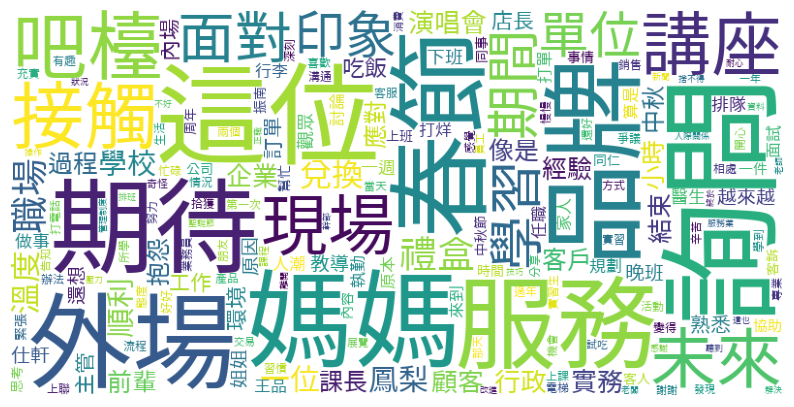

In [ ]:
dict_all_date = Wc_dict2(word_count_mon,500,10)

font = r'./taipei_sans_tc_beta.ttf'
# font = r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf' #中文字型路徑
wordcloud_all = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud_all.generate_from_frequencies(dict_all_date)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud_all)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

因為是實習日誌，我們可以看到很多跟工作相關的字眼，像是學習、主管、客人、實習、工作、公司、同事、時間。我們認為同學在寫實習日誌時會提到在實習期間跟同事的相處以及在工作時學習到很多新技能，特別是面對顧客的問題處理，因為我們多半是服務業。比較特別的是媽媽，有許多人可能在外地工作時，潛意識會特別思念親人，特別是媽媽。當中也有在保險業務的實習生，幫忙辦理親朋好友的保險，因而提到媽媽這個詞彙。百貨業中可以常常看到媽媽帶小孩的場景，因此在資料集中也多次提及。

#### 2018年7月 文字雲

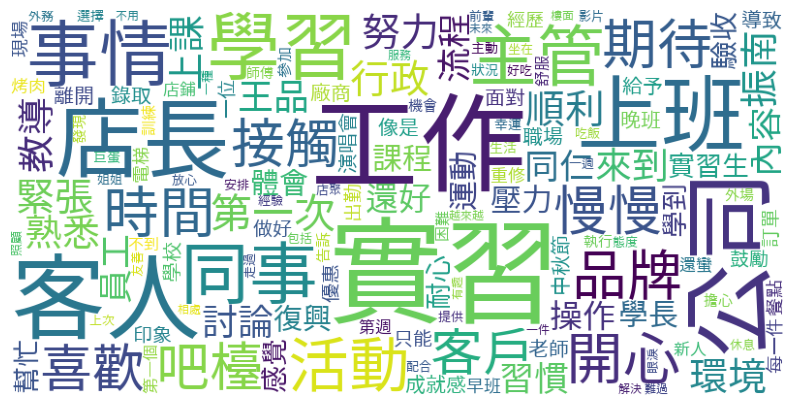

In [ ]:
dict_10707 = Wc_dict(word_count_mon,"2018-07",450,5)

font = r'./taipei_sans_tc_beta.ttf'
# font = r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_10707)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

除了上面total的，我們也做了一個七月的。由於七月是實習剛開始，有許多字眼像是學習、接觸、慢慢、第一次、期待、主管、店長等。這些會是在剛開始實習遇到的狀況，可能第一次接觸到的工作，並且期待在工作中能跟主管學習等。

### 2.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [ ]:
sentiment_sum = (word_count_mon.merge(df_ntusd, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

,word,sentiments,size
42,學習,positive,393
29,喜歡,positive,234
140,開心,positive,154
59,感謝,positive,132
17,努力,positive,124


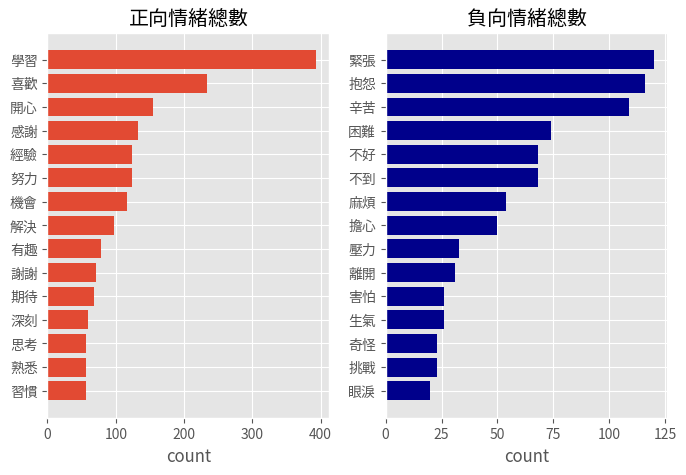

In [ ]:
#整個文集的情緒代表字
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

由正向情緒總數，我們可以看到學習、喜歡、開心、感謝是學生們常正面的地方，認為可能是學生們覺得實習是可以學習到在學校不能學到的東西，也很感謝老師們、主管給的實習機會。
實習工作時，會感到緊張、不習慣、辛苦，也會有工作壓力，覺得到一個新環境感到困難，可能想著要離開，逃離挑戰。

#### 每月情緒代表字
另外，也可以依據不同月分觀察情緒代表字的變化

In [ ]:
sentiment_date_sum = (word_count_mon.merge(df_ntusd, on='word')
                 .groupby(['artMonth', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選年/月份
sentiment_month = sentiment_date_sum[sentiment_date_sum['artMonth']=="2018-12"].sort_values(by=['size'], ascending=False)
sentiment_month.head()

,artMonth,word,sentiments,size
185,2018-12,學習,positive,65
205,2018-12,緊張,negative,38
178,2018-12,喜歡,positive,28
211,2018-12,解決,positive,22
204,2018-12,經驗,positive,22


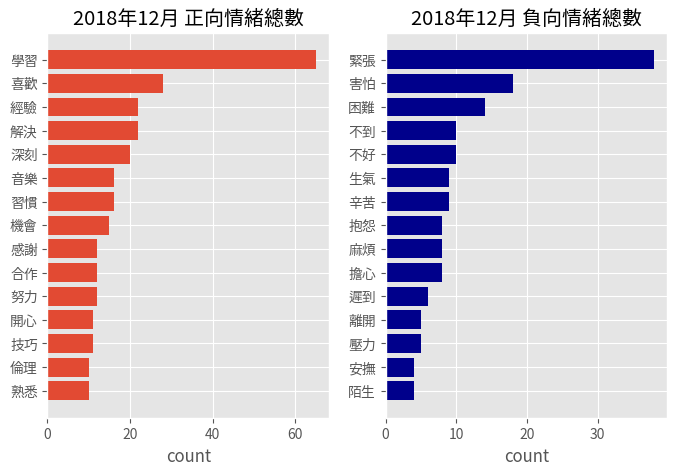

In [ ]:
#指定月份的情緒代表字
p_sum = sentiment_month[sentiment_month["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_month[sentiment_month["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('2018年12月 正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('2018年12月 負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

我們挑十二月是因為數據比較多。正面情緒有學習、喜歡、經驗、解決、深刻等，可能在實習一段時間之後，覺得自己有所成長，也會提到學習到了甚麼技能像是解決能力，對此感到開心。比較特別的是音樂，我們認為可能是12月聖誕節，服務業區域處處有音樂提振節日氣氛。
負向情緒常出現的字眼像是緊張、害怕、困難、生氣、辛苦。這些是在工作時會有的情緒，但有可能是因為在十二月聖誕節，特別多客人會在年末進行消費、送禮、吃飯局，讓工作量變高的學生產生負面情緒。

#### 個人情緒代表字
觀察不同實習生的情緒代表字變化

In [ ]:
sentiment_individual_sum = (word_count_intern.merge(df_ntusd, on='word')
                 .groupby(['intern_id', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選特定實習生個案
#篩出intern_id=39的個案資料
intern_spec_39 = sentiment_individual_sum[sentiment_individual_sum['intern_id']==39].sort_values(by=['size'], ascending=False)

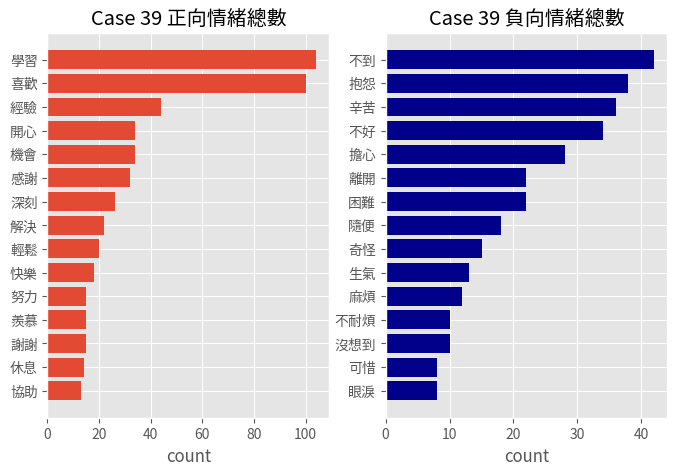

In [ ]:
#指定個案的情緒代表字
p_sum_39 = intern_spec_39[intern_spec_39["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum_39 = intern_spec_39[intern_spec_39["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式


plt.subplot(121)
plt.title('Case 39 正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum_39['word'],p_sum_39['size'])

plt.subplot(122)
plt.title('Case 39 負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum_39['word'],n_sum_39['size'],color="darkblue")


plt.show()

Case 39正向情緒總數，大多數正向字眼與總共的雷同，不一樣的有休息跟協助，可能因為實習的時間比較長，因此能有效利用時間休息以及獲得許多人的協助而感到開心。
Case 39負向情緒總數，較多的字眼有:抱怨、辛苦、擔心離開等。較特別的是不耐煩及隨便。可能覺得此個案在實習過程中對行政流程感到不理解，對效率低感到不耐煩。而隨便有特別看了一下他的內文，結果只是此人的口頭禪是隨便，很多不同的事情都用隨便來形容，像是不能態度隨便、重要的資料不能隨便亂放等。

### 2.7 歸類正負面日誌
之前的情緒分析大部分是全部的詞彙加總，接下來將正負面情緒的文章分開，看看能不能發現一些新的東西。
接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。

In [ ]:
article_type = (MetaData_token.merge(df_ntusd, on='word')
                .groupby(['content', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='content', columns='sentiments', values='size', fill_value=0)
                .reset_index(['content'])
               )
article_type.head()

sentiments,content,negative,positive
0,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,1,0
1,一個學期好快就過了剛進來舊振南實習的時候還覺得想那麼多幹嘛時間還久嘛但一眨眼一學期半年就過去...,3,3
2,一個月真的過的挺快的新年的第一個月要過完了呢也代表快要迎接過年的長假來囉月底又開始越來越悠閒...,5,2
3,一整個晚上跑了整個小巨蛋會場沒有停下只因為違規的觀眾太多沒有時間停下來喝水但也因為要將違規者...,2,4
4,一整天都是站梯外的導引對我來說導引比開電梯還要不容易因為導引承擔很多東西像是顧客的情緒等等但...,0,2


In [ ]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,416
1,positive,669


#### 正負情緒文章數量統計圖

In [ ]:
article_type_Month = article_type.merge(MetaData_token.loc[:,["content", "artMonth"]], how = 'left', on = 'content')
article_type_Month = article_type_Month.groupby(['artMonth','type'], as_index=False).size()
#article_type_date

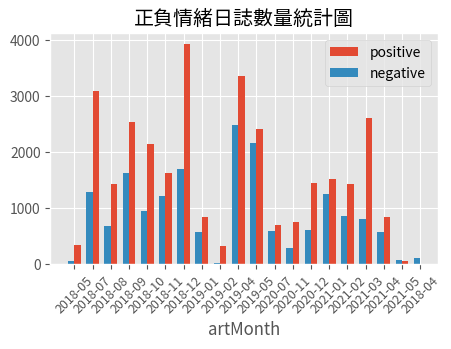

In [ ]:
ap = article_type_Month[(article_type_Month["type"]=="positive")]
an = article_type_Month[(article_type_Month["type"]=="negative")]

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('正負情緒日誌數量統計圖')
plt.xlabel('artMonth')
plt.bar(ap['artMonth'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artMonth'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artMonth')
plt.show()

正負情緒日誌數量統計圖可以看到正面情緒基本上皆高於負面情緒

## 3. Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)

#### 計算各詞彙在各文章中出現的次數

In [ ]:
#計算各詞彙在各文章中出現的次數
dia_word_count = MetaData_token.groupby(['content','word'],as_index=False).size()
dia_word_count.rename(columns={'size': 'count'}, inplace=True)

In [ ]:
dia_word_count

,content,word,count
0,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,上班,1
1,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,下班,1
2,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,休息時間,1
3,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,拾獲,1
4,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,時間,1
...,...,...,...
38990,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,開創,2
38991,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,開心,2
38992,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,關心,1
38993,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,難過,1


#### Pairwise correlation

In [ ]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
dia_fdist = FreqDist()
def dia_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    dia_fdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [ ]:
dia_bigram2 = MetaData.copy()
dia_bigram2["word"] = dia_bigram2.content.apply(dia_getToken_dict)

In [ ]:
dia_bigram2 = dia_bigram2.explode('word')

In [ ]:
#取常一起出現的bigram pair 前500筆
b = {k:v for k,v in dia_fdist.most_common(500)}
# b.items()

In [ ]:
#建立DataFrame
dia_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    dia_df = dia_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [ ]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(dia_word_count[dia_word_count["word"]==df["word"]]["content"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(dia_word_count[dia_word_count["word"]==df["word2"]]["content"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(dia_word_count[dia_word_count["word"]==df["word"]]["content"]) #單獨有x
    y_ls = list(dia_word_count[dia_word_count["word"]==df["word2"]]["content"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["content"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [ ]:
dia_df["cor"] = dia_df.apply(phi_cor, axis=1)
dia_df = dia_df[dia_df["word"]!=dia_df["word2"]]

In [ ]:
dia_df

,word,word2,n,cor
0,工作,內容,89,0.200834
1,實習,期間,72,0.176631
2,印象,深刻,55,0.608877
3,實習,結束,39,0.215523
4,學習,工作,37,0.174262
...,...,...,...,...
495,同事,請假,4,0.021481
496,慢慢,整理,4,0.037106
497,公司,實習生,4,0.110159
498,回去,上班,4,0.135926


### 3.1 和 客人, 學習 相關性最高的 15 個詞彙

In [ ]:
c_sum = dia_df[(dia_df["word"]=="客人")].sort_values(by=['cor'], ascending = False).head(15)
b_sum = dia_df[(dia_df["word"]=="學習")].sort_values(by=['cor'], ascending = False).head(15)

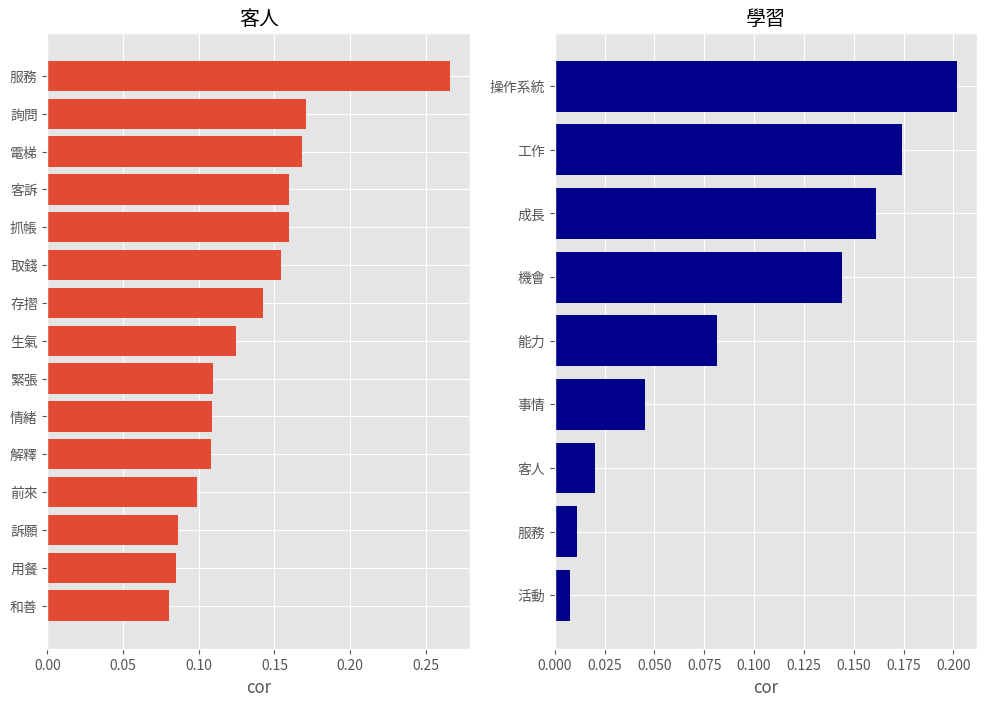

In [ ]:
c_sum = c_sum.sort_values(by=['cor'])
b_sum = b_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('客人')
plt.xlabel('cor')
plt.barh(c_sum['word2'],c_sum['cor'])

plt.subplot(122)
plt.title('學習')
plt.xlabel('cor')
plt.barh(b_sum['word2'],b_sum['cor'],color="darkblue")


plt.show()


我們挑客人跟學習來當作我們的關聯，原本是挑實習跟工作，但出來的東西並不有趣，所以最後選了客人跟學習。最多與客人的關聯詞是互動的部分，不論正面還是負面的互動，以及有一些在互動中所產生的情緒。學習的部分大多是在實習的過程中所學到的人事物，像是操作系統、學習能力等。


## 4. 結論

  本次資料來源是某一位老師提供他學生的實習學習日誌，我們原先有實作tf-idf跟n-gram。在tf-idf的部分，因為內容不外乎是學生本身日常的實習心得，重點很明顯都在實習工作上所以就不進行關鍵字詞分析；而n-gram原本是想延伸做出字詞之間的correaltion圖，基於學生在實習日誌上寫的內容都是高度重複並且句型語法過於近似，萃取出來的東西並沒有太大的實質意義(實際Correaltion圖產出會發現是一個圓)。那位老師原本是希望能挖掘學生在實習中最常碰到的問題，也想看到學生實習的成效及留任程度。**遇到的問題可以從負面情緒中猜測出來，而學生們都覺得實習能學習到不一樣的東西，對此感到快樂以及開心；負面情緒則有可能因為工作不順、壓力大、或是主管責備等而顯現出來**。至於留任程度，由於只有整個實習過程的最後一週才會決定要不要留任，因此在我們的文字分析上面出現次數過少而未呈現出來。
  本次分析我們能看到學生的**學習日誌回饋大致上趨於正面，而老師也向學生詢問其原因，結果是因為怕老師將日誌也給實習廠商看因此內容非常客套、表面**，日後若要更深入了解學生實際狀況還是以實體訪談較為準確。